# Plot the output of count_events.py

In [2]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import oskar

### Import data

In [3]:
rid = '20160318_153639'
h5 = oskar.H5Data(rid)              # data
out_dire = h5.out_dire("Count")     # output
# log 
h5.load_log()
logDF = h5.log
varDF = h5.vDF()
uDF = h5.uDF()
# count data
NAMES = ['CH_A0', 'CH_A1']
allDF = h5.load_count(NAMES, include_vars=True)

In [4]:
uDF

,DLY_EA,IR,UV,VOL_u100,VOL_u101
VID,,,,,
1,5.950000e-07,735.6035,243.2,2000,2000
2,5.950000e-07,736.4084,243.2,2000,2000
3,5.950000e-07,737.3534,243.2,2000,2000
4,5.950000e-07,738.4732,243.2,2000,2000
5,5.950000e-07,739.8138,243.2,2000,2000
6,5.950000e-07,741.4379,243.2,2000,2000
7,5.950000e-07,743.4321,243.2,2000,2000
8,5.950000e-07,745.9188,243.2,2000,2000
9,5.950000e-07,749.0765,243.2,2000,2000


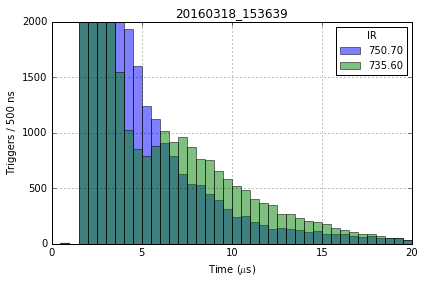

In [6]:
## plot setup
fig, ax = plt.subplots()
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

max_amp = 0.025
max_width = 0.5e-6

# select data
VIDS = [10, 1]
for vid in VIDS:
    # select data
    data = allDF[((allDF[uDF.columns] == uDF.loc[vid]).all(1))]
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    ax.hist(trigs, bins=bins, alpha=0.5, label='%.2f'%uDF.loc[vid, 'IR'])
    
#format
plt.axhline(0, color='k', alpha=0.5)
lgd = ax.legend(loc=0, fontsize=10, title='IR')
ax.set_ylabel("Triggers / 500 ns");
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_ylim(0,2000)
plt.title(rid);
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_triggers.png')
plt.savefig(fileout, dpi=150)

In [24]:
import f2mods as f2
from positronium.constants import Ryd_Ps
from scipy.constants import m_e, k, micro
from lmfit import minimize, Parameters, report_fit
def n_val(IR):
    return np.sqrt(-1.0/(1.0/ (IR * Ryd_Ps) - 0.25))

In [15]:
t0 = 2.22e-06

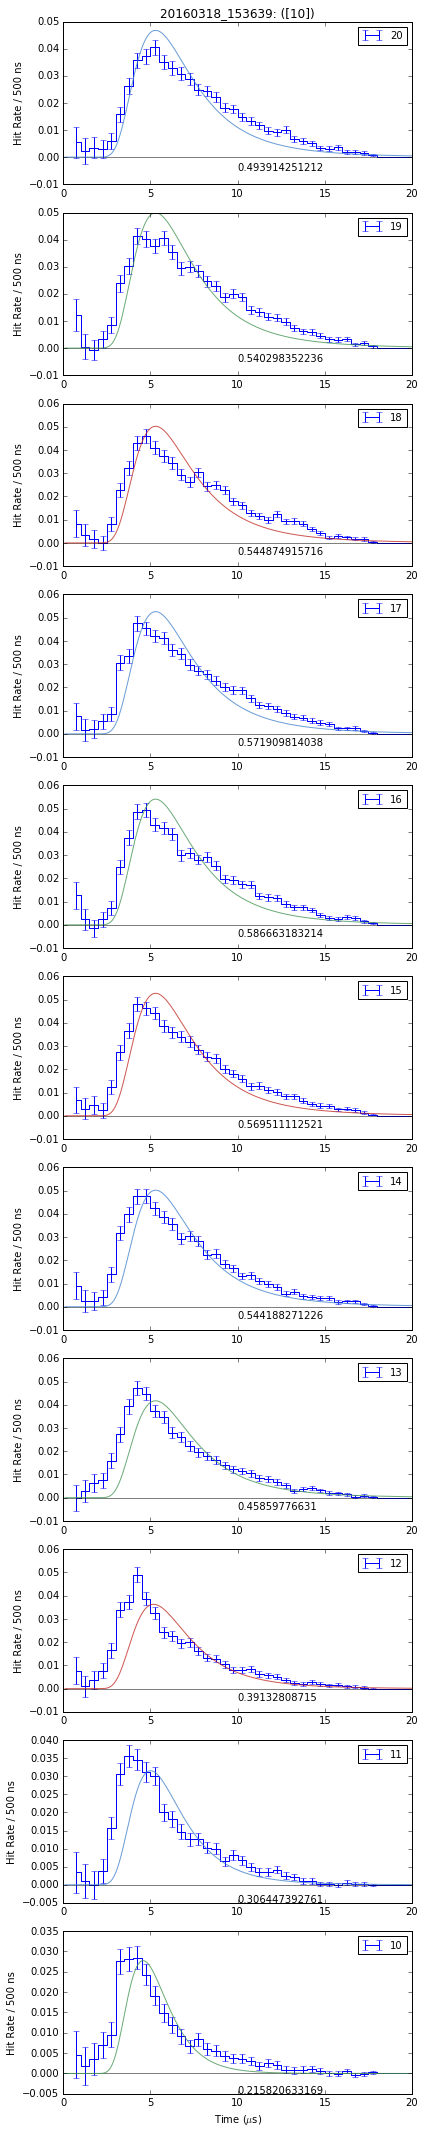

In [140]:
# histogram bins
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

# background
vid_off = [10]
# select data
data = allDF[(allDF[uDF.columns] == uDF.loc[vid_off[0]]).all(1)]
acq_off = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
# cut triggers
data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
trigs = (data['trigger'].values - t0)*1e6
n_off = np.histogram(trigs, bins=bins)
x = n_off[1][:-1]+bin_width/2

# data
VIDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
n_rows = len(VIDS)
#plot setup
fig, ax = plt.subplots(n_rows, 1, figsize=(6,2.7*n_rows))
ax = np.array([ax]).flatten()
j = 0
hr = []
n_values = []
all_data = []
all_err = []
zero_err = 0.0005
for vid in VIDS:
    # delay 1
    # select data
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values - t0)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # normalise and subtract background
    y =  np.subtract(n_on[0]/ acq_on, n_off[0] / acq_off)
    yerr  = np.add(np.sqrt(n_on[0])/ acq_on, np.sqrt(n_off[0])/ acq_off)
    n = (round(n_val(f2.rad_cal(uDF.loc[vid].IR) * 1e-9)))
    n_values.append(n)
    ax[j].errorbar(x, y, yerr=yerr, drawstyle='steps-mid', label='%d'%n)
    ax[j].legend(loc=0, fontsize=10)
    ax[j].set_ylabel("Hit Rate / 500 ns")
    ax[j].axhline(0, color='k', alpha=0.5)
    ax[j].text(10, -0.005,y[5:].sum())
    hr.append(y[4:].sum())
    # collect data
    all_data.append(y)
    fear = np.array([zero_err if ye == 0 else ye for ye in yerr])
    all_err.append(fear)
    j = j + 1

all_data = np.array(all_data)
all_err = np.array(all_err)
assert(all_data.shape) == np.shape(all_data)

M = 2*m_e
d = 1.24

def f(x, A, tau, T):
    v = d/ x
    vbar = np.sqrt(np.divide(k * T, M))
    return np.divide(v, x) * A * np.exp(-x/(tau*micro)) * np.divide(np.power(v, 3), 2.0 * vbar**4) * np.exp(np.divide(-np.power(v,2), 2 * vbar**2))

def dataset(params, i, x):
    A = params['A_%i' % (i+1)].value
    tau = params['tau_%i' % (i+1)].value
    T = params['T_%i' % (i+1)].value
    return f(x, A, tau, T)

def objective(params, x, data, err):
    ndata, nx = data.shape
    resid = 0.0*data[:]
    weighted = 0.0*data[:]
    for i in range(ndata):
        resid[i, :] = data[i, :] - dataset(params, i, x)
        weighted[i, :] = (data[i, :] - dataset(params, i, x))/ err[i,:]
    return weighted.flatten()

fit_params = Parameters()
for iy, y in enumerate(all_data):
    fit_params.add( 'A_%i' % (iy+1), value=1e-7, min=1e-18,  max=1e-2)
    fit_params.add( 'tau_%i' % (iy+1), value=1, min=0.1,  max=40)
    fit_params.add( 'T_%i' % (iy+1), value=5000, min=100, max=10000)

# but now constrain decay and T
for iy in range(len(all_data)+1)[2:]:
    fit_params['T_%i' % iy].expr='T_1'

# run the global fit to all the data sets
fit = minimize(objective, fit_params, args=(x*micro, all_data, all_err))

for kk in range(11):
    xl = np.linspace(0, 20, 201)
    y_fit = dataset(fit.params, kk, xl * micro)
    ax[kk].plot(xl, y_fit, '-', c=oskar.colors[kk%3], alpha=0.8)

# format
ax[-1].set_xlabel(r"Time ($\mu$s)");
ax[0].set_title(rid + ': (' + str(vid_off) + ')');

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_bsub.png')
plt.savefig(fileout, dpi=150)
plt.show()

In [141]:
report_fit(fit)

[[Fit Statistics]]
    # function evals   = 1043
    # data points      = 429
    # variables        = 23
    chi-square         = 2866.610
    reduced chi-square = 7.061
[[Variables]]
    A_1:      2.7925e-07 +/- 0        (0.00%) (init= 1e-07)
    tau_1:    40         +/- 0        (0.00%) (init= 1)
    T_1:      1411.90191 +/- 0        (0.00%) (init= 5000)
    A_2:      2.9803e-07 +/- 0        (0.00%) (init= 1e-07)
    tau_2:    39.9999999 +/- 0        (0.00%) (init= 1)
    T_2:      1411.90191 +/- 0        (0.00%)  == 'T_1'
    A_3:      2.9967e-07 +/- 0        (0.00%) (init= 1e-07)
    tau_3:    40         +/- 0        (0.00%) (init= 1)
    T_3:      1411.90191 +/- 0        (0.00%)  == 'T_1'
    A_4:      3.1410e-07 +/- 0        (0.00%) (init= 1e-07)
    tau_4:    40         +/- 0        (0.00%) (init= 1)
    T_4:      1411.90191 +/- 0        (0.00%)  == 'T_1'
    A_5:      3.2293e-07 +/- 0        (0.00%) (init= 1e-07)
    tau_5:    40         +/- 0        (0.00%) (init= 1)
    T_5:

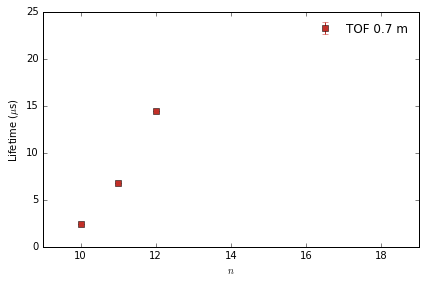

In [142]:
tau_vals = [fit.params.get('tau_'+str(kk+1)).value for kk in range(11)]
tau_errs = [fit.params.get('tau_'+str(kk+1)).stderr for kk in range(11)]

#fit

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(n_values, tau_vals, yerr=tau_errs, fmt='s', c=oskar.colors[2], label='TOF 0.7 m')
#ax.errorbar([12, 18], [3.01485721, 9.26889887], yerr=[0.261626, 1.073776], fmt='o', c=oskar.colors[0], label='TOF 1.2 m')
#plt.plot(xf, y3, c=oskar.colors[0], ls='--', label = r'$y = $ %.2e $n^4$'%coeff[0])
# format
plt.axhline(0, color='k', alpha=0.5)
ax.legend(loc=0, frameon=False, fontsize=12, numpoints = 1)
ax.set_ylabel(r"Lifetime ($\mu$s)");
ax.set_xlabel(r"$n$");
ax.set_ylim([0, 25])
ax.set_xlim([9, 19])

# save data
plt.tight_layout();
fileout = os.path.join("C:\Users\Adam\Dropbox\Documents\Articles\Rydberg_PRA",  'TOF_long_n_fit.pdf')
#plt.savefig(fileout, dpi=600, bbox_inches='tight')
plt.show()

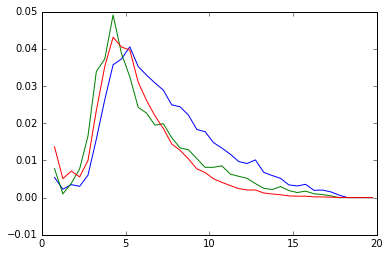

In [69]:
A = 2.95
tau = 4.757
plt.plot(x, all_data[0])
plt.plot(x, all_data[-3])
plt.plot(x, A * all_data[0] * np.exp(-x / tau))

In [92]:
fit_params = Parameters()
fit_params.add( 'A', value=1, min=0.1,  max=10)
fit_params.add( 'tau', value=1, min=0.1,  max=200)

def objective(params, x, data0, data):
    tau0 = 30.0
    A = params['A'].value
    tau = params['tau'].value
    return data * np.exp(-x / tau0) - A * data0 * np.exp(-x / tau)

In [124]:
fit = minimize(objective, fit_params, args=(x, all_data[0], all_data[-8]))
report_fit(fit)

[[Fit Statistics]]
    # function evals   = 46
    # data points      = 39
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    A:     1.46446975 +/- 0.092416 (6.31%) (init= 1)
    tau:   14.0865450 +/- 2.043889 (14.51%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(A, tau)                    = -0.951 


In [109]:
fits = np.array([[10, 3.20357821, 0.308924], [11, 4.38611453, 0.529825], [12, 4.75742146, 0.520467], [13, 8.30419840, 1.098477], 
[14, 13.6885340, 2.116043], [15, 25.7155654, 5.144], [16, 32.831013, 10.2], [17, 32.4251390, 9.652841]]).T

fits2 = np.array([[10, 2.96152121, 0.273918], [11, 3.84151692, 0.434690], [12, 3.99001384, 0.378423], [13, 6.29532537, 0.704279], 
[14, 8.70514690, 0.938674], [15, 12.7257491, 1.390893], [16, 14.0523090, 2.101597], [17, 14.0865450, 2.043889], [18, 17.2330611, 2.804847], [19, 21.2961734, 4.674969]]).T

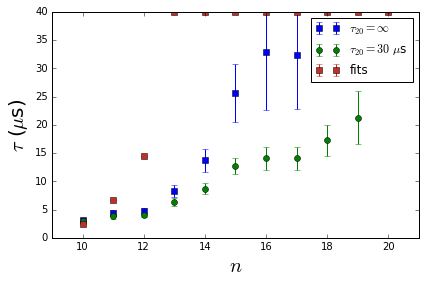

In [145]:
plt.errorbar(fits[0], fits[1], yerr=fits[2], fmt='s', label=r'$\tau_{20} = \infty$')
plt.errorbar(fits2[0], fits2[1], yerr=fits2[2], fmt='o', label=r'$\tau_{20} = 30$ $\mu$s')
plt.errorbar(n_values, tau_vals, yerr=tau_errs, fmt='s', c=oskar.colors[2], label='fits')
plt.legend(loc=0)
plt.xlabel(r'$n$', fontsize=20) 
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=20)
plt.ylim(0,40)
plt.xlim(9,21)
# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_tau.png')
plt.savefig(fileout, dpi=150)
plt.show()